# YELP DATASET


# Goal: Explore Data


### Business

>  Rating Stars distribution accross businesses

### User

> Elite User vs Non-Elite User

> Number of users in each one-year period category

> Number of years it takes to convert yelp user to elite user

> Timeline of yelp user sign up

> Number of elite users each year

### Review

> Piechart - Number of users in each number of reviews categories

Dataset Source: https://www.yelp.com/dataset_challenge

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition.online_lda import LatentDirichletAllocation
import string
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib


# Read Data

In [2]:
user = pd.read_csv('csv/user.csv')
business = pd.read_csv('csv/business.csv')
review = pd.read_csv('csv/review.csv')
tip = pd.read_csv('csv/tip.csv')

/Users/Charlotte/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,4,7,17,26,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
print(len(business),len(user),len(review))

85901 686543 2685066


In [3]:
def rename_column(file):
    new_names = list()
    for col in file:
        new_names.append(col.replace('.', '_', len(col)).replace(' ', '_', len(col)).lower())
    return new_names

In [4]:
user.columns = rename_column(user.columns)
business.columns = rename_column(business.columns)
business.columns = [ re.sub('attributes_', '', c) for c in business.columns ]
review.columns = rename_column(review.columns)

In [5]:
user = user.ix[user['review_count'] != 0]
user = user.drop(['type','friends'],axis = 1 )

In [6]:
review = review.drop('type',axis = 1)
business = business.drop('type',axis = 1)
tip = tip.drop('type',axis = 1)

In [7]:
user = user.reset_index()

# Data visualization

## Business Rating

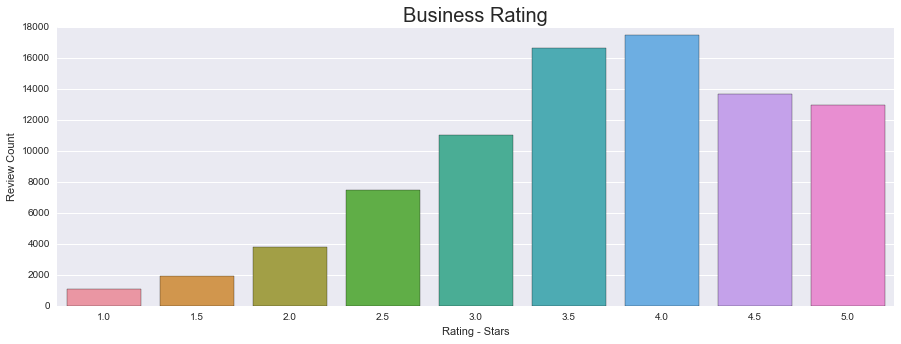

In [8]:
plt.figure(figsize=(15,5))
sns.countplot(business['stars'])
plt.title('Business Rating', fontsize=20)
plt.xlabel('Rating - Stars')
plt.ylabel('Review Count')

## Elite Status

In [9]:
# to find how many users in each elite year period
user['elite_year']  = [ len(i.split(',')) for i in user['elite']]

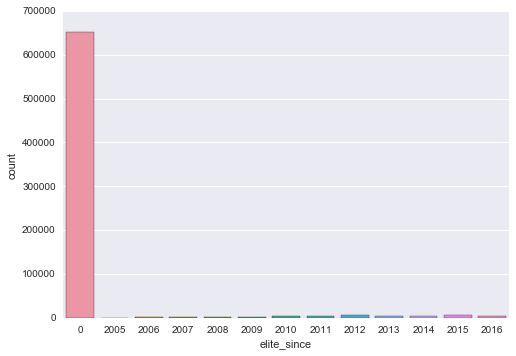

In [40]:
sns.countplot(user['elite_since'])

In [76]:
# plt.figure(figsize=(15,5))
# sns.countplot(user['elite_year'])
# plt.title('Distribution of Elite User',fontsize=20)
# plt.xlabel('Year')
# plt.ylabel('User Count')

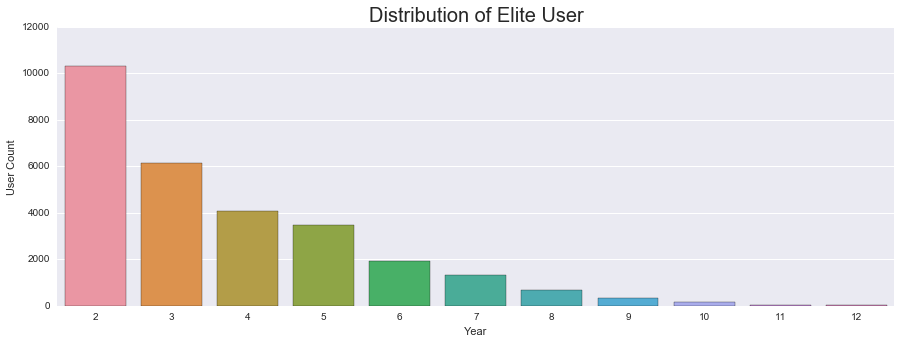

In [11]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_year'].ix[user['elite_year'] != 1])
plt.title('Distribution of Elite User',fontsize=20)
plt.xlabel('Year')
plt.ylabel('User Count')

# Number of years since  Yelp Membership Start Year until Elite Status

In [12]:
user['elite_since'] = [i.replace('[','').replace(']','').split(',')[0] for i in user['elite']]

In [13]:
user['elite_since'] = [int(i) if i!= '' else 0 for i in user['elite_since'] ]

In [14]:
user['year_before_elite'] = [ user['elite_since'][i] - int(user['yelping_since'][i].split("-")[0]) if  user['elite_since'][i]!= 0 else 0 for i in range(686543)]

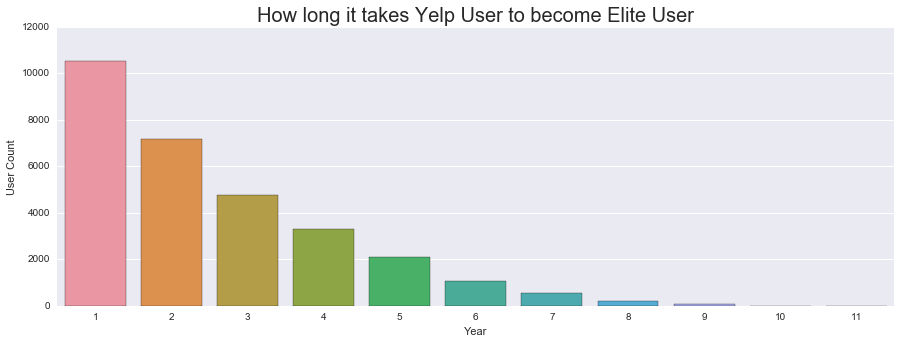

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(user['year_before_elite'].ix[user['year_before_elite']!= 0])
plt.title('How long it takes Yelp User to become Elite User',fontsize=20)
plt.xlabel('Year')
plt.ylabel('User Count')

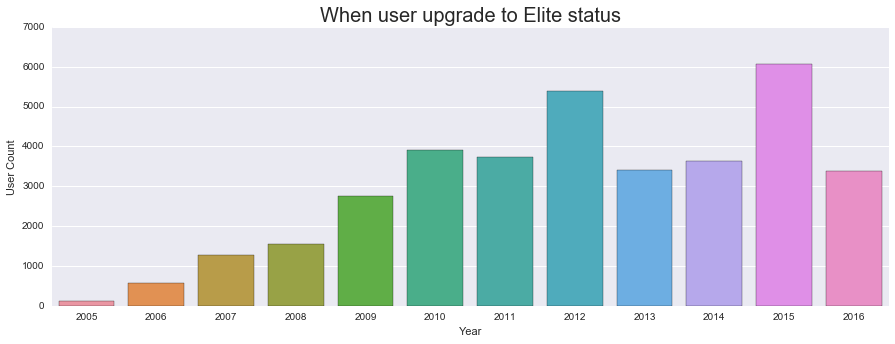

In [16]:
plt.figure(figsize=(15,5))
sns.countplot(user['elite_since'].ix[user['elite_since']!= 0])
plt.title('When user upgrade to Elite status',fontsize=20)
plt.xlabel('Year')
plt.ylabel('User Count')

In [17]:
elite_dict = Counter(user['year_before_elite'])

In [18]:
elite_pd = pd.DataFrame(list(elite_dict.items()),index = None,columns = ['year','user_count'])

In [19]:
member_since = user.groupby('yelping_since')['user_id'].count()
member_since = pd.DataFrame(member_since)

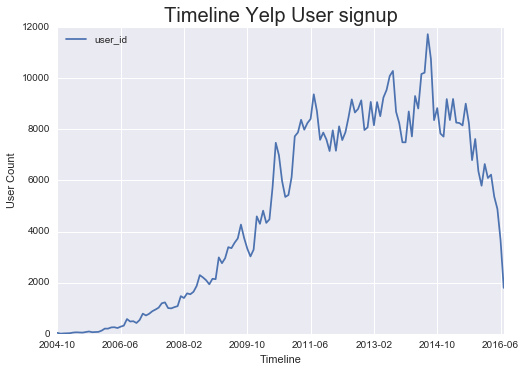

In [20]:
member_since.plot()
plt.title('Timeline Yelp User signup',fontsize=20)
plt.xlabel('Timeline')
plt.ylabel('User Count')

# Review

In [67]:
a = Counter(user['review_count'])
b = Counter(a.values()) # key : #review -- value: user count
b = dict(b)

In [79]:
c = pd.DataFrame(list(b.items()),index = None,columns = ['review','user_count'])
print(len(c))
c.head(5)

266


,review,user_count
0,1,383
1,2,150
2,3,96
3,4,74
4,5,41


In [69]:
c['percentage'] = [(c.user_count[i] * 100/sum(c.user_count)) for i in range(266)]

In [70]:
reviews_dict = dict()
label = ['one','two','three']
for i,label in enumerate(label):
    reviews_dict[label] = c.percentage[i]

In [71]:
reviews_dict['four2ten']= sum(c.percentage[3:10])
reviews_dict['ten2hundred']= sum(c.percentage[10:100])
reviews_dict['more_than_hundred']= sum(c.percentage[100:-1])

In [72]:
reviews_dict

{'four2ten': 17.796030116358658,
 'more_than_hundred': 13.2785763175907,
 'one': 26.21492128678987,
 'ten2hundred': 25.80424366872001,
 'three': 6.5708418891170428,
 'two': 10.266940451745381}

In [73]:
review_pd = pd.DataFrame(list(reviews_dict.items()),index = None,columns = ['review','user_percentage'])
review_pd

,review,user_percentage
0,one,26.214921
1,four2ten,17.796030
2,ten2hundred,25.804244
3,three,6.570842
4,two,10.266940
5,more_than_hundred,13.278576


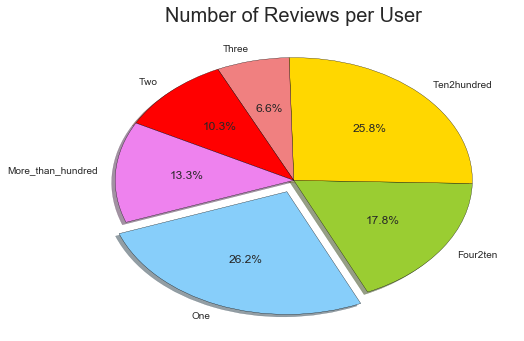

In [75]:
labels =[ i.capitalize() for i in  review_pd['review']]
sizes = review_pd['user_percentage']
colors = ['lightskyblue','yellowgreen', 'gold', 'lightcoral','red','violet']
explode = (0.1, 0, 0,0,0, 0) 

plt.pie(sizes, explode=explode,labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=200,center=(0,1));
plt.title('Number of Reviews per User',fontsize=20)